# Mean-field and full simulations of unstructured network

## Dynamics

$$\alpha_d\left(\Theta^t\right) = 
\int_{x}\mathcal{N}\left(x; \mu_d, \sigma_d^2\right) \prod_{d'\neq d} \Phi\left(x; \mu_{d'}, \sigma_{d'}^2\right)$$

$$\mu_d = D \sum_{d'} \mu_J(d,d') \Theta_{d'}^t + u_d^t \quad \quad \sigma^2_d = D \sum_{d'} \sigma_J^2(d,d') \Theta_{d'}^t + v_d^t$$

Infinite networks

$$\Theta^{t+1} = \boldsymbol{\alpha}(\Theta^t)$$

Finite networks

$$N\Theta^{t+1} \sim \textrm{Multinomial}\left(\boldsymbol{\alpha}(\Theta^t), N\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -20
X_MAX = 20

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

# Unstructured network

In [3]:
NS = [np.inf, 1000, 300]

In [4]:
t_max = 51
t = np.arange(t_max)

D = 5

t_u = 25
us = {t_u: (np.arange(D) < 2).astype(float)}

ths_all = []

for N in NS:

    sys.stdout.write('.')

    MU_J = np.zeros((D, D))
    SGM_J = np.ones((D, D))

    th_0 = 1 + np.random.randn(D)*.01
    th_0 /= th_0.sum()

    ths = np.nan*np.zeros((t_max, D))
    ths[0, :] = th_0

    for t_ in t[1:]:
        
        u = us[t_] if t_ in us else 0
        ths[t_, :] = alph(ths[t_-1, :], u=u, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J, N=N)
        
    ths_all.append(ths)

...

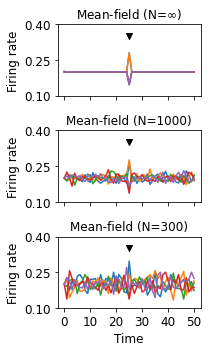

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(3, 5), tight_layout=True, sharex=True)
for N, ths, ax in zip(NS, ths_all, axs):
    ax.plot(ths)
    ax.scatter(t_u, .35, marker='v', c='k')
    
    if ax is axs[-1]:
        ax.set_xlabel('Time')
        
    title = f'Mean-field (N={N})' if not np.isinf(N) else r'Mean-field (N=$\infty$)'
    set_plot(ax, x_ticks=np.arange(0, t_max, 10), y_ticks=(.1, .25, .4), y_label='Firing rate', title=title)
    
fig.savefig('figs/main/3_mft_smln_unstructured.svg')

# Full simulation

In [6]:
from ntwk import SoftmaxNtwk

In [7]:
MU_J = np.zeros((D, D))
SGM_J = np.ones((D, D))

xs_all = []
ys_all = []

NS_FULL = [5000] + NS[1:]

for N in NS_FULL:
    print(f'N = {N}')
    J = np.nan*np.zeros((D, D, N, N))

    for d_to in range(D):
        for d_from in range(D):
            J[d_to, d_from, :, :] = SGM_J[d_to, d_from]*np.sqrt(D/N)*np.random.randn(N, N) + MU_J[d_to, d_from]*D/N

    ntwk = SoftmaxNtwk(J)
    
    u_ptb = np.zeros((N, D))
    u_ptb[:, np.arange(D) < 2] = 1
    us_full = {t_u: u_ptb}

    x_0 = np.random.randn(N, D)
    g = np.inf
    t, xs, ys = ntwk.run(g=g, t_max=t_max, x_0=x_0, us=us_full, progress=10)

    xs_all.append(xs)
    ys_all.append(ys)
    
    print('')

N = 5000
.....
N = 1000
.....
N = 300
.....


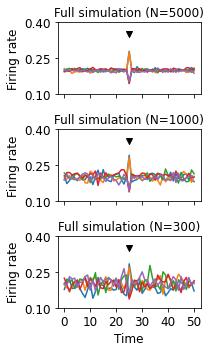

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(3, 5), tight_layout=True, sharex=True)
for N, ys, ax in zip(NS_FULL, ys_all, axs):
    ths = ys.mean(1)
    
    ax.plot(ths)
    ax.scatter(t_u, .35, marker='v', c='k')
    
    if ax is axs[-1]:
        ax.set_xlabel('Time')
    set_plot(ax, x_ticks=np.arange(0, t_max, 10), y_ticks=(.1, .25, .4), y_label='Firing rate', title=f'Full simulation (N={N})')
    
fig.savefig('figs/main/3_full_smln_unstructured.svg')

# Input distributions

Theory:

Driven case:

$$\mu_d = 1, \sigma_d^2 = D$$

Non-driven case:

$$\mu_d = 0, \sigma_d^2 = D$$

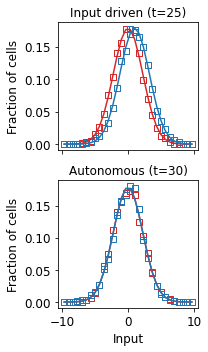

In [9]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(2, 1, figsize=(3, 5), tight_layout=True, sharex=True)

xs = xs_all[0]

xs_u = xs[t_u, :, 0]
xs_u_not = xs[t_u, :, -2]

xs_1 = xs[30, :, 0]
xs_1_not = xs[30, :, -2]

bins = np.linspace(-10, 10, 31)
binc = .5*(bins[:-1] + bins[1:])
db = np.mean(np.diff(bins))

p_u = np.histogram(xs_u, bins=bins, density=True)[0]
p_u_not = np.histogram(xs_u_not, bins=bins, density=True)[0]
axs[0].scatter(binc, p_u_not, facecolors='none', edgecolors=colors[D-2], marker='s')
axs[0].scatter(binc, p_u, facecolors='none', edgecolors=colors[0], marker='s')

p_1 = np.histogram(xs_1, bins=bins, density=True)[0]
p_1_not = np.histogram(xs_1_not, bins=bins, density=True)[0]
axs[1].scatter(binc, p_1_not, facecolors='none', edgecolors=colors[D-2], marker='s')
axs[1].scatter(binc, p_1, facecolors='none', edgecolors=colors[0], marker='s')

# theoretical predictions
x_thry_non = stats.norm.pdf(binc, 0, np.sqrt(D))
x_thry_driven = stats.norm.pdf(binc, 1, np.sqrt(D))

axs[0].plot(binc, x_thry_non, c=colors[D-2])
axs[0].plot(binc, x_thry_driven, c=colors[0])
axs[0].set_title(f'Input driven (t={t_u})')

axs[1].plot(binc, x_thry_non, c=colors[D-2])
axs[1].plot(binc, x_thry_non, c=colors[0])
axs[1].set_title(f'Autonomous (t=30)')

axs[1].set_xlabel('Input')

for ax in axs:
    set_plot(ax, y_label='Fraction of cells')
    
fig.savefig('figs/main/3_mft_full_inputs.svg')